# SageMaker JumpStart - Image Generation

---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook.

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/introduction_to_amazon_algorithms|jumpstart-foundation-models|image-generation-stable-diffusion.ipynb)

---

---
Welcome to [Amazon SageMaker Jumpstart](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)! You can use Amazon SageMaker Jumpstart to solve many Machine Learning tasks through one-click in SageMaker Studio, or through [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/overview.html#use-prebuilt-models-with-sagemaker-jumpstart).

In this demo notebook, we demonstrate how to use the SageMaker Python SDK to deploy Stable Diffusion models for image generation task. The container being utilized here is a customized stabilityai container that has been optimized to excel in terms of both speed and quality. We demonstrate how to use SageMaker Python SDK for Text-to-Image and Image-to-Image generation. Text-to-Image is the task of generating realistic image given any text input. Here, we show how to use state-of-the-art pre-trained Stable Diffusion models for generating image from text and image.

---

1. [Set Up](#1.-Set-Up)
2. [Select a model](#2.-Select-a-model)
3. [Deploy an endpoint & Query endpoint](#3.-Deploy-an-Endpoint-&-Query-endpoint)
4. [Clean Endpoint](#4.-Clean-Endpoint)

### 1. Set Up

---
Before executing the notebook, there are some initial steps required for set up

---

In [2]:
%pip install --upgrade sagemaker --quiet

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 2. Select a pre-trained model

In [3]:
model_id = "model-imagegeneration-stabilityai-stable-diffusion-xl-base-1-0"

In [4]:
import IPython
from ipywidgets import Dropdown
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models
from sagemaker.jumpstart.filters import And


filter_value = And("task == imagegeneration")
ss_models = list_jumpstart_models(filter=filter_value)

dropdown = Dropdown(
    value=model_id,
    options=ss_models,
    description="Sagemaker Pre-Trained Image Generation Models:",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)
display(IPython.display.Markdown("## Select a pre-trained model from the dropdown below"))
display(dropdown)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## Select a pre-trained model from the dropdown below

Dropdown(description='Sagemaker Pre-Trained Image Generation Models:', index=1, layout=Layout(width='max-conte…

### 3. Deploy an Endpoint & Query Endpoint

***

Using SageMaker, we can perform inference on the pre-trained model.

***

In [5]:
# Deploying the model
from sagemaker.jumpstart.model import JumpStartModel
from sagemaker.serializers import JSONSerializer
import time

# The model is deployed on the ml.g5.4xlarge instance. To see all the supported parameters by the JumpStartModel
# class use this link - https://sagemaker.readthedocs.io/en/stable/api/inference/model.html#sagemaker.jumpstart.model.JumpStartModel
my_model = JumpStartModel(model_id=dropdown.value)
predictor = my_model.deploy()
# We will wait for a few seconds so model is properly loaded.
time.sleep(60)

Using model 'model-imagegeneration-stabilityai-stable-diffusion-xl-base-1-0' with wildcard version identifier '*'. You can pin to version '1.0.1' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


---------------!

Importing relevant packages for querying endpoint and image visualization

In [6]:
from PIL import Image
import io
import base64
import json
import boto3
from typing import Union, Tuple
import os

## Query Stable Diffusion endpoint

### Supported features

***
This model supports many advanced parameters while performing inference. They include:

* **text**: prompt to guide the image generation. Must be specified and should be string.
* **width**: width of the hallucinated image. If specified, it must be a positive integer divisible by 8.
* **height**: height of the hallucinated image. If specified, it must be a positive integer divisible by 8. Image size should be larger than 256x256.
* **sampler**: Available samplers are EulerEDMSampler, HeunEDMSampler,EulerAncestralSampler, DPMPP2SAncestralSampler, DPMPP2MSampler, LinearMultistepSampler
* **cfg_scale**: A higher cfg_scale results in image closely related to the prompt, at the expense of image quality. If specified, it must be a float. cfg_scale<=1 is ignored.
* **steps**: number of denoising steps during image generation. More steps lead to higher quality image. If specified, it must a positive integer.
* **seed**: fix the randomized state for reproducibility. If specified, it must be an integer.
* **use_refiner**: Refiner is used by defauly with the SDXL model. You can disbale it by using this parameter
* **init_image**: Image to be used as the starting point.
* **image_strength**: Indicates extent to transform the reference image. Must be between 0 and 1.
* **refiner_steps**: Number of denoising steps during image generation for the refiner. More steps lead to higher quality image. If specified, it must a positive integer.
* **refiner_strength**: Indicates extent to transform the input image to the refiner.
* **negative_prompt**: guide image generation against this prompt. If specified, it must be a string. It is specified in the text_prompts with a negative weight.


***
### Text to Image

***

In [7]:
payload = {
    "text_prompts": [{"text": "jaguar in the Amazon rainforest"}],
    "width": 1024,
    "height": 1024,
    "sampler": "DPMPP2MSampler",
    "cfg_scale": 7.0,
    "steps": 50,
    "seed": 133,
    "use_refiner": True,
    "refiner_steps": 40,
    "refiner_strength": 0.2,
}

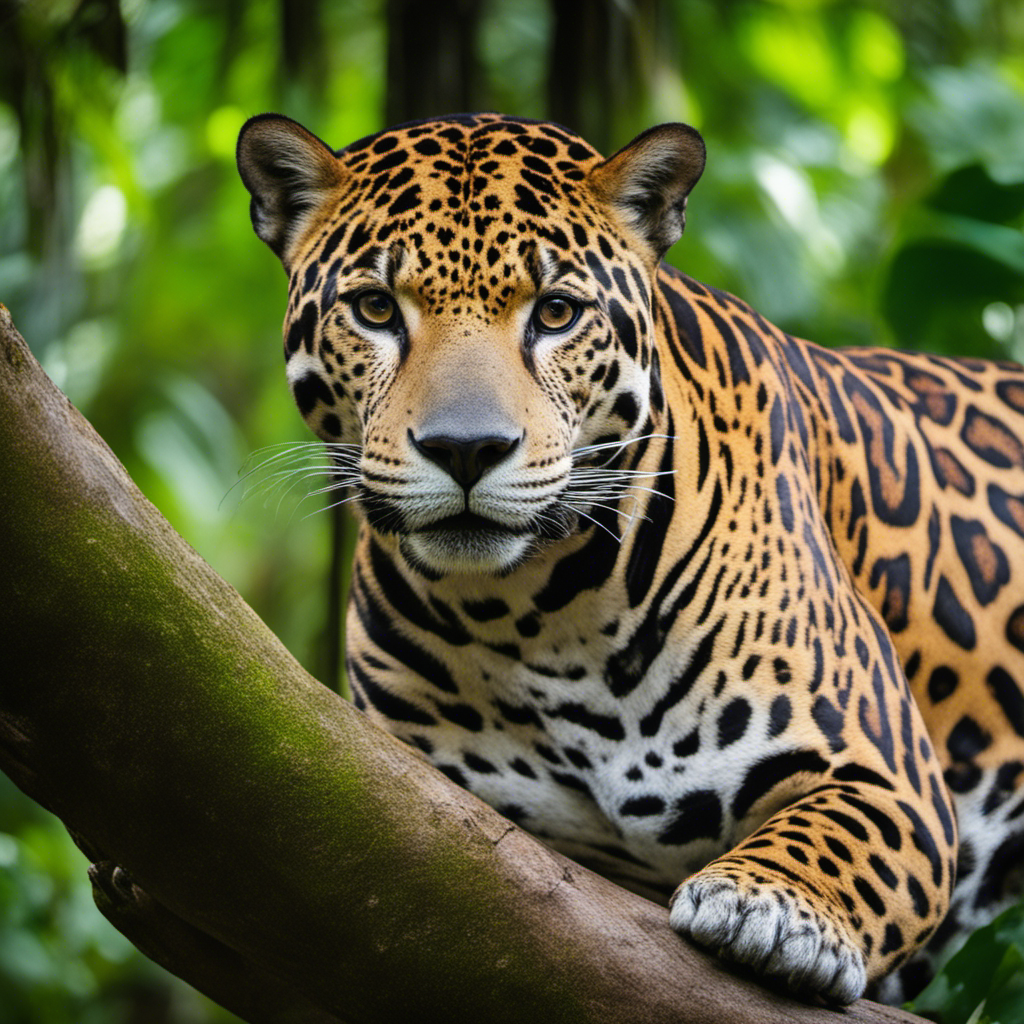

In [8]:
def decode_and_show(model_response) -> None:
    """
    Decodes and displays an image from SDXL output

    Args:
        model_response (GenerationResponse): The response object from the deployed SDXL model.

    Returns:
        None
    """
    image = Image.open(io.BytesIO(base64.b64decode(model_response)))
    display(image)
    image.close()


response = predictor.predict(payload)
# If you get time out error please check the endpoint logs in cloudWatch for model loading status
# and invoke it again
decode_and_show(response["generated_image"])

### Image to Image

***
To perform inference that takes an image as input, you must pass the image into init_image as a base64-encoded string.

Below is a helper function for converting images to base64-encoded strings:

***

In [9]:
def encode_image(
    image_path: str, resize: bool = True, size: Tuple[int, int] = (1024, 1024)
) -> Union[str, None]:
    """
    Encode an image as a base64 string, optionally resizing it to a supported resolution.

    Args:
        image_path (str): The path to the image file.
        resize (bool, optional): Whether to resize the image. Defaults to True.

    Returns:
        Union[str, None]: The encoded image as a string, or None if encoding failed.
    """
    assert os.path.exists(image_path)

    if resize:
        image = Image.open(image_path)
        image = image.resize(size)
        image.save("image_path_resized.png")
        image_path = "image_path_resized.png"
    image = Image.open(image_path)
    assert image.size == size
    with open(image_path, "rb") as image_file:
        img_byte_array = image_file.read()
        # Encode the byte array as a Base64 string
        try:
            base64_str = base64.b64encode(img_byte_array).decode("utf-8")
            return base64_str
        except Exception as e:
            print(f"Failed to encode image {image_path} as base64 string.")
            print(e)
            return None
    image.close()

Let's feed an image into the model as well as the prompt this time. We can set image_strength to weight the relative importance of the image and the prompt. For the demo, we'll use a picture of the dog.

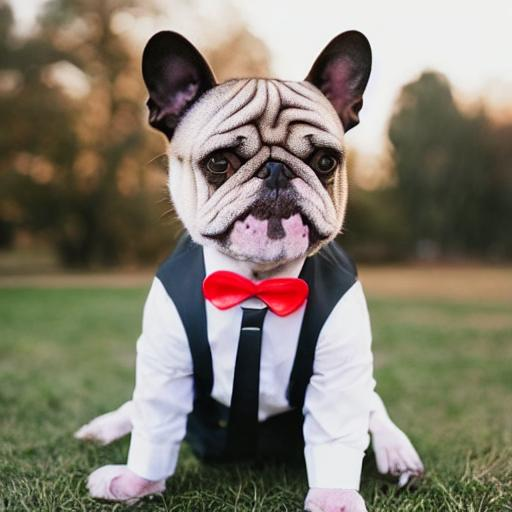

In [10]:
# Here is the original image:
region = boto3.Session().region_name
s3_bucket = f"jumpstart-cache-prod-{region}"
key_prefix = "model-metadata/assets"
input_img_file_name = "dog_suit.jpg"

s3 = boto3.client("s3")

s3.download_file(s3_bucket, f"{key_prefix}/{input_img_file_name}", input_img_file_name)
image = Image.open(input_img_file_name)
display(image)
image.close()

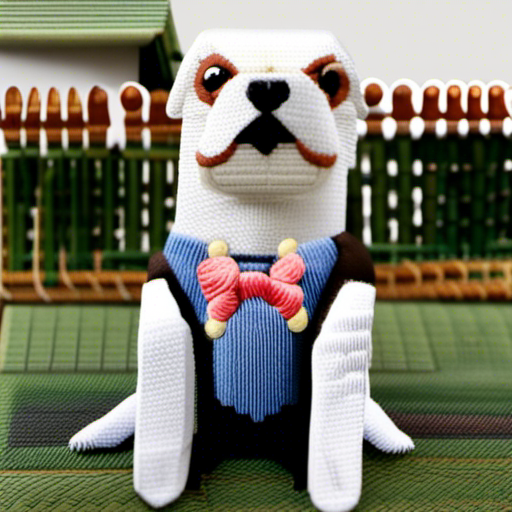

In [11]:
size = (512, 512)
dog_data = encode_image(input_img_file_name, size=size)

payload = {
    "text_prompts": [{"text": "dog in embroidery"}],
    "init_image": dog_data,
    "cfg_scale": 9,
    "image_strength": 0.8,
    "seed": 42,
}

response = predictor.predict(payload)
decode_and_show(response["generated_image"])

### 4. Clean Endpoint


In [ ]:
# Delete the SageMaker endpoint
predictor.delete_model()
predictor.delete_endpoint()

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/introduction_to_amazon_algorithms|jumpstart-foundation-models|image-generation-stable-diffusion.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/introduction_to_amazon_algorithms|jumpstart-foundation-models|image-generation-stable-diffusion.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/introduction_to_amazon_algorithms|jumpstart-foundation-models|image-generation-stable-diffusion.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/introduction_to_amazon_algorithms|jumpstart-foundation-models|image-generation-stable-diffusion.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/introduction_to_amazon_algorithms|jumpstart-foundation-models|image-generation-stable-diffusion.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/introduction_to_amazon_algorithms|jumpstart-foundation-models|image-generation-stable-diffusion.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/introduction_to_amazon_algorithms|jumpstart-foundation-models|image-generation-stable-diffusion.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/introduction_to_amazon_algorithms|jumpstart-foundation-models|image-generation-stable-diffusion.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/introduction_to_amazon_algorithms|jumpstart-foundation-models|image-generation-stable-diffusion.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/introduction_to_amazon_algorithms|jumpstart-foundation-models|image-generation-stable-diffusion.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/introduction_to_amazon_algorithms|jumpstart-foundation-models|image-generation-stable-diffusion.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/introduction_to_amazon_algorithms|jumpstart-foundation-models|image-generation-stable-diffusion.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/introduction_to_amazon_algorithms|jumpstart-foundation-models|image-generation-stable-diffusion.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/introduction_to_amazon_algorithms|jumpstart-foundation-models|image-generation-stable-diffusion.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/introduction_to_amazon_algorithms|jumpstart-foundation-models|image-generation-stable-diffusion.ipynb)